# Dirac Notation Implementation - DEMO

2024-03-01

## Set up the environment

In [1]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
session = WolframLanguageSession()

In [2]:
from diracdec import *
from diracdec import dirac_bigop_delta_parse as parse, dirac_bigop_delta_trs as trs

In [3]:
sub = Subst({
    "ket0" : parse('''KET('0')'''),
    "bra0" : parse('''BRA('0')'''),
    "ket1" : parse('''KET('1')'''),
    "bra1" : parse('''BRA('1')'''),
    "ketP" : parse(''' "Sqrt[1/2]" SCR (ket0 ADD ket1) '''),
    "braP" : parse(''' "Sqrt[1/2]" SCR (bra0 ADD bra1) '''),
    "ketM" : parse(''' "Sqrt[1/2]" SCR (ket0 ADD ("-1" MLTK ket1)) '''),
    "braM" : parse(''' "Sqrt[1/2]" SCR (bra0 ADD ("-1" MLTB bra1)) '''),

    "beta00" : parse(''' "Sqrt[1/2]" SCR ((ket0 TSR ket0) ADD (ket1 TSR ket1))'''),

    "I2" : parse('''(ket0 OUTER bra0) ADD (ket1 OUTER bra1)'''),

    "Z" : parse('''(ket0 OUTER bra0) ADD ("-1" SCR (ket1 OUTER bra1))'''),

    "X" : parse('''(ket0 OUTER bra1) ADD (ket1 OUTER bra0)'''),

    "Y" : parse('''("-I" SCR (ket0 OUTER bra1)) ADD ("I" SCR (ket1 OUTER bra0))'''),


    "H" : parse(''' "Sqrt[1/2]" SCR ((ket0 OUTER bra0) ADD (ket0 OUTER bra1) ADD (ket1 OUTER bra0) ADD ("-1" SCR (ket1 OUTER bra1)))'''),

    "CX": parse(''' ((ket0 TSR ket0) OUTER (bra0 TSR bra0))
                ADD ((ket0 TSR ket1) OUTER (bra0 TSR bra1)) 
                ADD ((ket1 TSR ket1) OUTER (bra1 TSR bra0))
                ADD ((ket1 TSR ket0) OUTER (bra1 TSR bra1))'''),

    "CZ": parse(''' ((ket0 TSR ket0) OUTER (bra0 TSR bra0))
                ADD ((ket0 TSR ket1) OUTER (bra0 TSR bra1)) 
                ADD ((ket1 TSR ket0) OUTER (bra1 TSR bra0))
                ADD ("-1" SCR ((ket1 TSR ket1) OUTER (bra1 TSR bra1)))'''),

}).get_idempotent()


In [4]:
print(sub)

┌───────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                           │
│ CZ ↦ (((|0>⊗|1>)⊗(<0|⊗<1|)) + ((|0>⊗|0>)⊗(<0|⊗<0|)) + (-1.((|1>⊗|1>)⊗(<1|⊗<1|))) + ((|1>⊗|0>)⊗(<1|⊗<0|))) │
│                                                                                                           │
│ ket0 ↦ |0>                                                                                                │
│                                                                                                           │
│        ⎛   1                    ⎞                                                                         │
│ braM ↦ ⎜-------.(<0| + (-1·<1|))⎟                                                                         │
│        ⎝Sqrt[2]                 ⎠                                                                         │
│         

## Examples

### Utilizing Wolfram Engine

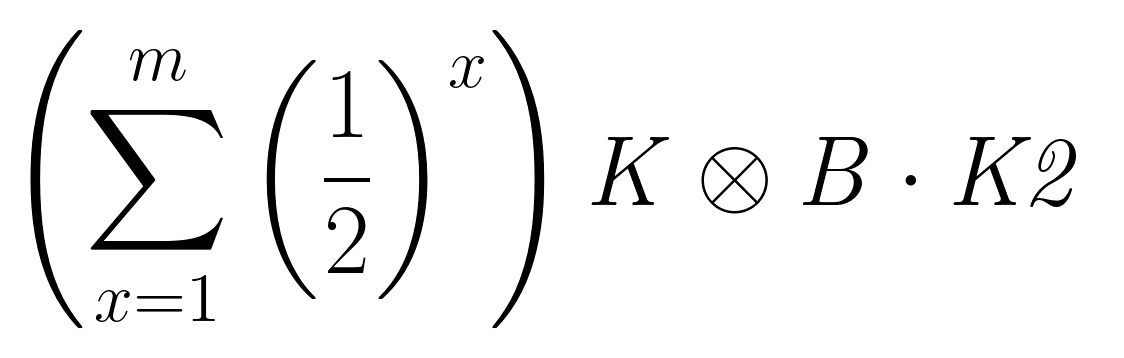

In [32]:
expr = parse(''' "HoldForm[Sum[(1/2)^x, {x, 1, m}]]" SCR ((K OUTER B) MLTK K2) ''')
expr.render_tex()

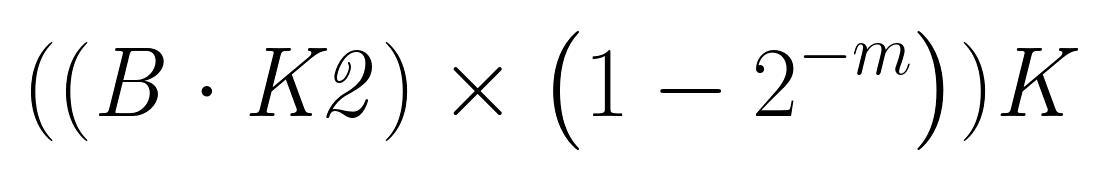

In [33]:
trs.normalize(expr).render_tex()

### Rotation decompostion

In [34]:

# define the rotation gates
sub_rot = Subst({
    "Rz" : sub(parse(
        ''' FUN beta . ( ("Cos[beta/2]" SCR I2) ADD ("- Sin[beta/2] I" SCR Z) )'''
        )),

    "Ry" : sub(parse(
        ''' FUN gamma . ( ("Cos[gamma/2]" SCR I2) ADD ("- Sin[gamma/2] I" SCR Y) )'''
        )),
})


# get the idempotent operation
new_sub = sub_rot.composite(sub).get_idempotent()

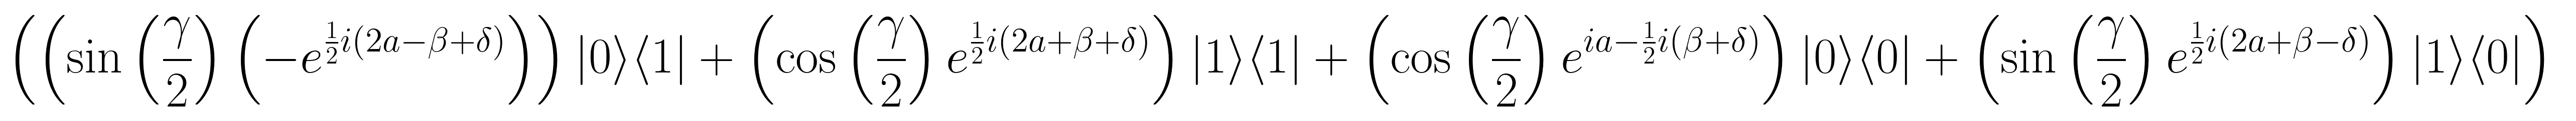

In [35]:
# RHS - rotations
a = new_sub(parse(''' "Exp[I a]" SCR ((Rz @ beta) MLTO (Ry @ gamma) MLTO (Rz @ delta)) '''))
norm_a = trs.normalize(sub(a))
norm_a.render_tex()

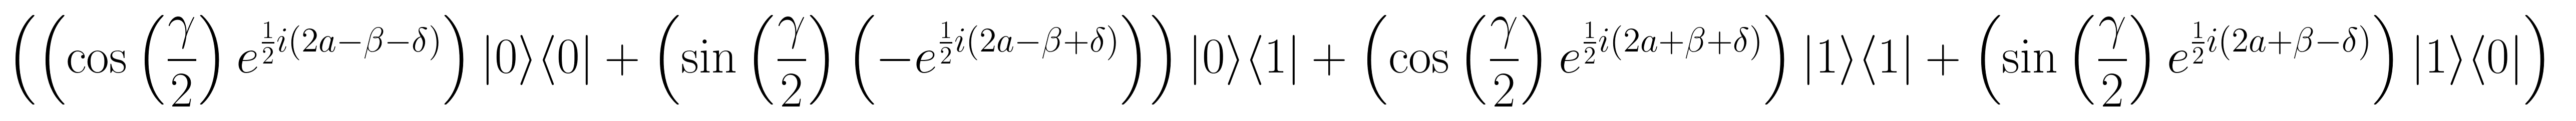

In [36]:
b = new_sub(parse(''' ("Exp[I (a - beta/2 - delta/2)] Cos[gamma/2]" SCR (ket0 OUTER bra0))
    ADD ("- Exp[I (a - beta/2 + delta/2)] Sin[gamma/2]" SCR (ket0 OUTER bra1)) 
    ADD ("Exp[I (a + beta/2 - delta/2)] Sin[gamma/2]" SCR (ket1 OUTER bra0))
    ADD ("Exp[I (a + beta/2 + delta/2)] Cos[gamma/2]" SCR (ket1 OUTER bra1))'''))
norm_b = trs.normalize(sub(b))
norm_b.render_tex()

In [37]:
print("equivalence without unique scalar table: ", norm_a == norm_b)
print("equivalence with unique: scalar table: ", wolU(norm_a) == wolU(norm_b))

equivalence without unique scalar table:  False
equivalence with unique: scalar table:  True


### Operation on Maximally Entangled State

For all $A$,
$$
A_{S} \ket{\Phi}_{S, T} = A^\top_{T} \ket{\Phi}_{S, T}
$$
where
$$
\ket{\Phi} = \sum_{i}\ket{i}\ket{i}
$$

In [38]:
a = parse(''' 
                (
                    (
                        SUM(i, KET(i) OUTER BRA(i)) TSR 1O
                    ) 
                    MLTO (A TSR 1O)
                ) 
                MLTK 
                (
                    SUM(i, KET(PAIR(i, i)))
                ) 
            ''')

b = parse(''' 
                (
                    (1O TSR SUM(i, KET(i) OUTER BRA(i))) MLTO (1O TSR TP(A))
                ) 
                MLTK 
                (
                    SUM(i, KET(PAIR(i, i)))
                ) 
            ''')

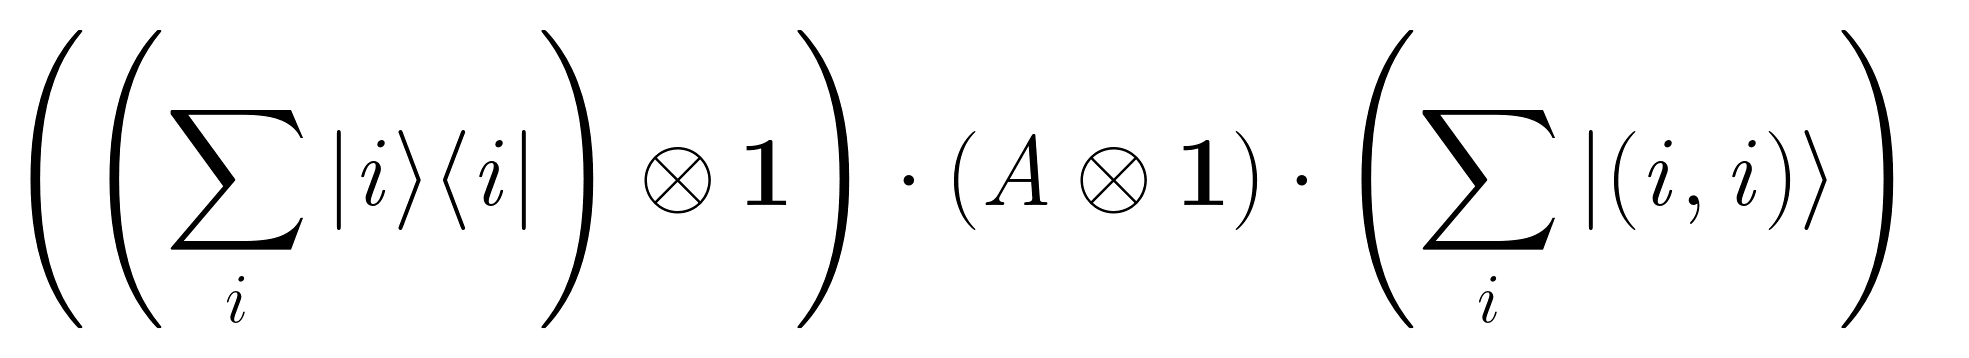

In [39]:
a.render_tex()

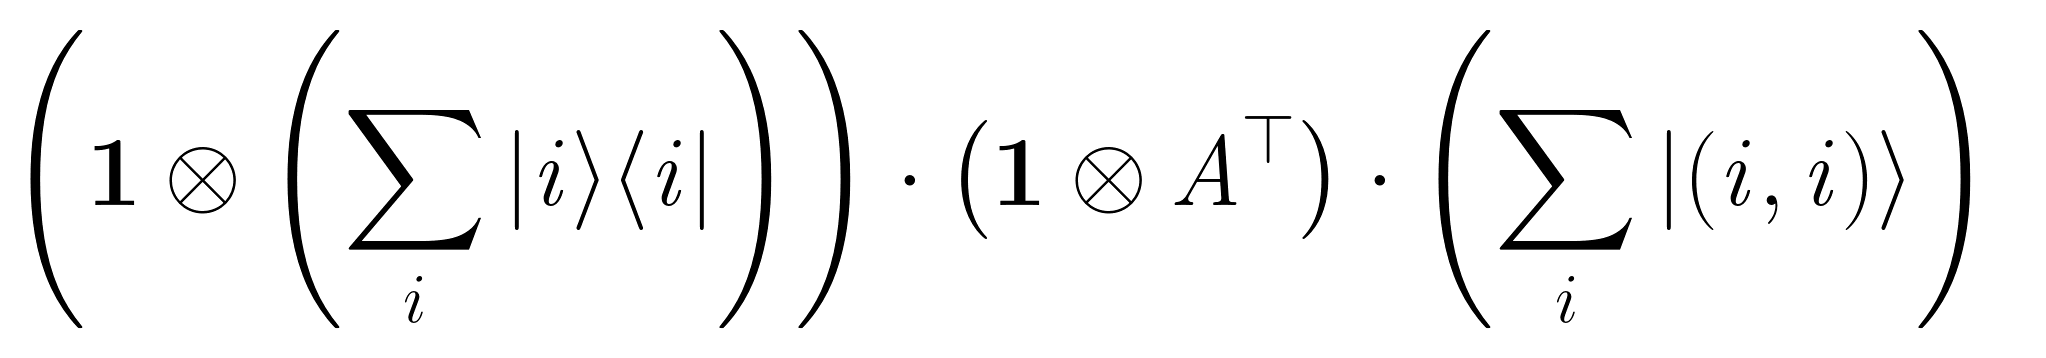

In [40]:
b.render_tex()

In [41]:
norm_a = trs.normalize(a)
norm_b = trs.normalize(b)

assert trs.normalize(juxt(sumeq(norm_a))) == trs.normalize(juxt(sumeq(norm_b)))

In [42]:
trs.normalize(a, verbose=True)

== STEP 1 ==
Current Term:
⎛⎛⎛__            ⎞      ⎞ __         ⎞
⎜⎜⎜\             ⎟      ⎟ \          ⎟
⎜⎜⎜/  (|i>⊗<i|)⊗𝟏⎟·(A⊗𝟏)⎟·/  |(i, i)>⎟
⎜⎜⎜‾‾            ⎟      ⎟ ‾‾         ⎟
⎝⎝⎝i             ⎠      ⎠ i          ⎠

┌apply OPT-MLT-12────────────────────────────────────┐
│⎛⎛__            ⎞      ⎞    ⎛⎛__            ⎞      ⎞│
│⎜⎜\             ⎟      ⎟    ⎜⎜\             ⎟      ⎟│
│⎜⎜/  (|i>⊗<i|)⊗𝟏⎟·(A⊗𝟏)⎟ -> ⎜⎜/  (|i>⊗<i|)·A⎟⊗(𝟏·𝟏)⎟│
│⎜⎜‾‾            ⎟      ⎟    ⎜⎜‾‾            ⎟      ⎟│
│⎝⎝i             ⎠      ⎠    ⎝⎝i             ⎠      ⎠│
└────────────────────────────────────────────────────┘

== STEP 2 ==
Current Term:
⎛⎛⎛__            ⎞      ⎞ __         ⎞
⎜⎜⎜\             ⎟      ⎟ \          ⎟
⎜⎜⎜/  (|i>⊗<i|)·A⎟⊗(𝟏·𝟏)⎟·/  |(i, i)>⎟
⎜⎜⎜‾‾            ⎟      ⎟ ‾‾         ⎟
⎝⎝⎝i             ⎠      ⎠ i          ⎠

== STEP 1 ==
Current Term:
((|i>⊗<i|)·A)

┌apply OPT-MLT-5───────────────┐
│((|i>⊗<i|)·A) -> (|i>⊗(<i|·A))│
└──────────────────────────────┘

== STEP 2 ==
Current Term:

SUM[x0](SUM[i](((BRA(i) DOT (A MLTK KET(x0))) SCR KET(PAIR(i, x0)))))

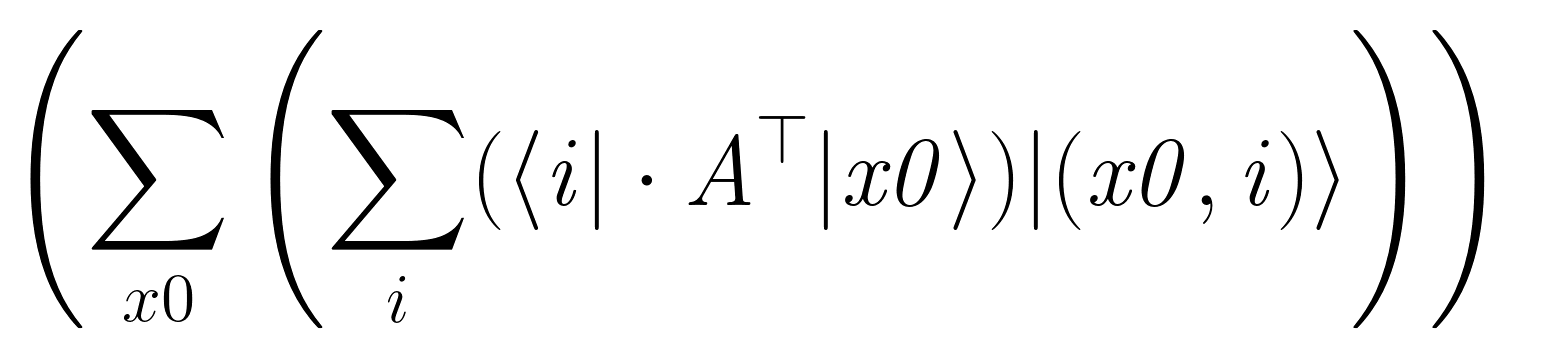

In [43]:
trs.normalize(b).render_tex()

### abstraction and application: Choi representation

In [44]:
choi_sub = Subst({
"choi" : parse(r''' 
FUN A . SUM(i, 
            SUM(j, 
                (BRA(i) DOT (A MLTK KET(j)))
                SCR KET(PAIR(i,j))
            )    
        ) '''),
"unchoi" : parse(r'''
FUN A . SUM(i,
            SUM(j,
                (BRA(PAIR(i, j)) DOT A)
                SCR (KET(i) OUTER BRA(j))
                )
        )''')
}).get_idempotent()

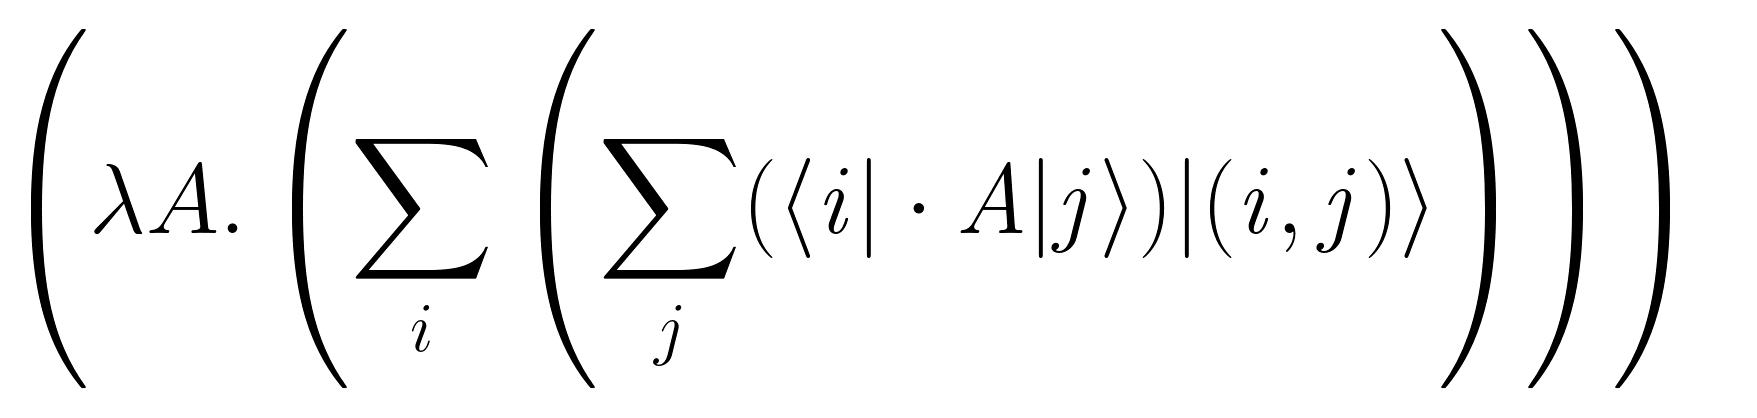

In [45]:
a = choi_sub(parse(r'''choi'''))
a.render_tex()

In [46]:
print(a)

⎛    __ __                         ⎞
⎜    \  \                          ⎟
⎜λ A./  /  ((<i|·(A·|j>)).|(i, j)>)⎟
⎜    ‾‾ ‾‾                         ⎟
⎝    i  j                          ⎠


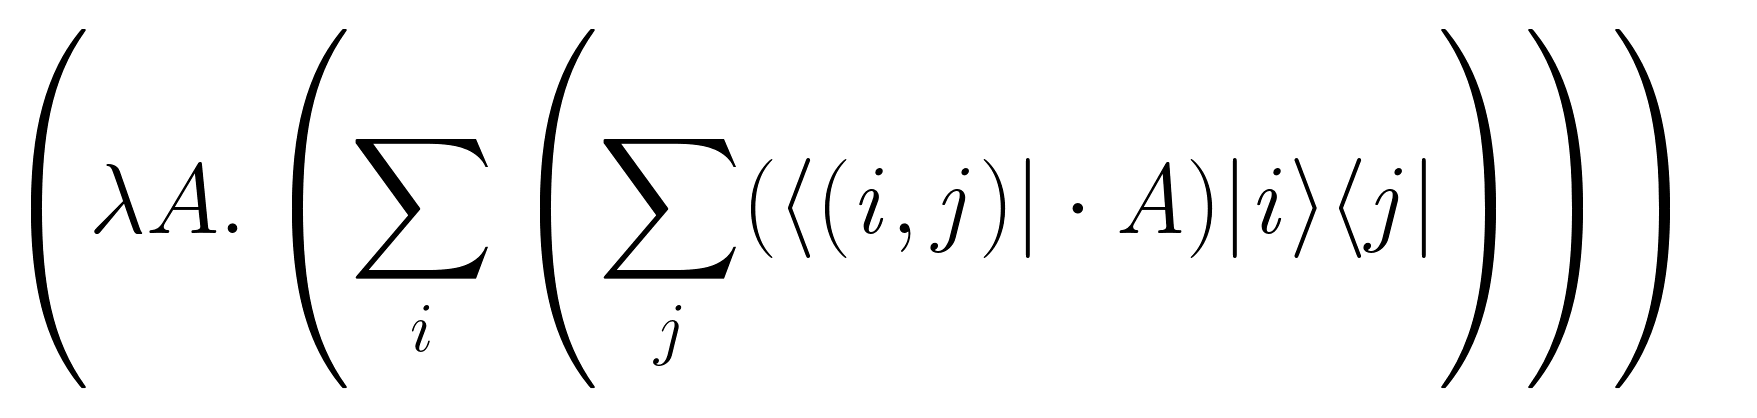

In [47]:
b = choi_sub(parse(r'''unchoi'''))
b.render_tex()

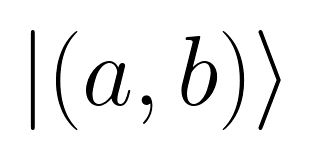

In [48]:
a_ = choi_sub(parse(r''' choi @ (KET('a') OUTER BRA('b')) '''))
trs.normalize(a_).render_tex()

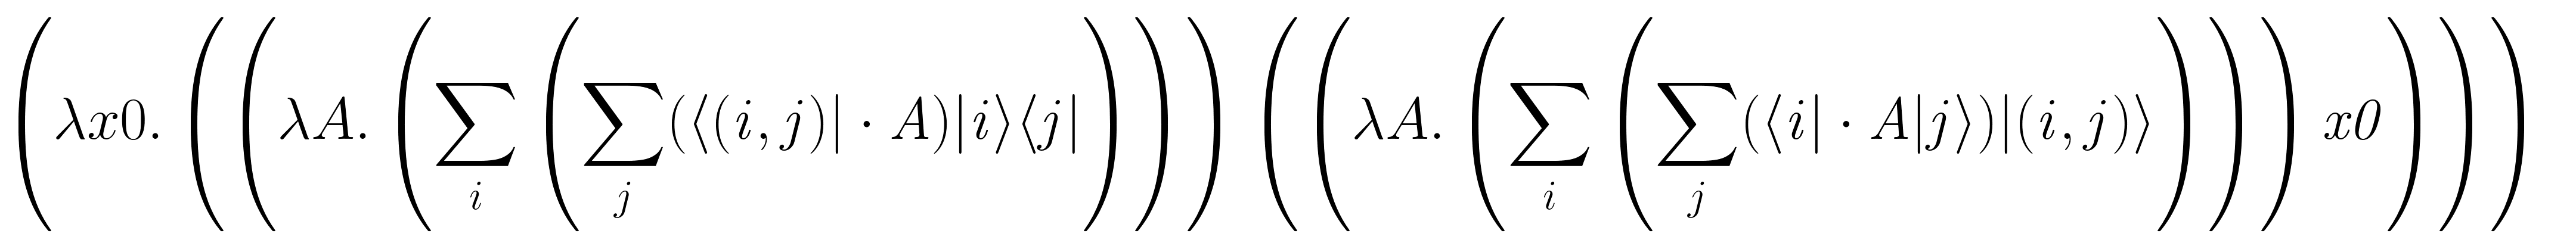

In [49]:
c = choi_sub(parse(r'''FUN A . unchoi @ (choi @ A) '''))
c.render_tex()

In [50]:
trs.normalize(c, verbose=True)

== STEP 1 ==
Current Term:
⎛     ⎛    __ __                         ⎞ ⎛    __ __                         ⎞   ⎞
⎜     ⎜    \  \                          ⎟ ⎜    \  \                          ⎟   ⎟
⎜λ x0.⎜λ A./  /  ((<(i, j)|·A).(|i>⊗<j|))⎟ ⎜λ A./  /  ((<i|·(A·|j>)).|(i, j)>)⎟ x0⎟
⎜     ⎜    ‾‾ ‾‾                         ⎟ ⎜    ‾‾ ‾‾                         ⎟   ⎟
⎝     ⎝    i  j                          ⎠ ⎝    i  j                          ⎠   ⎠

┌apply BETA-REDUCTION──────────────────────────────────────────────────────┐
│⎛    __ __                         ⎞       __ __                          │
│⎜    \  \                          ⎟       \  \                           │
│⎜λ A./  /  ((<i|·(A·|j>)).|(i, j)>)⎟ x0 -> /  /  ((<i|·(x0·|j>)).|(i, j)>)│
│⎜    ‾‾ ‾‾                         ⎟       ‾‾ ‾‾                          │
│⎝    i  j                          ⎠       i  j                           │
└──────────────────────────────────────────────────────────────────────────┘

== STEP 2 ==

LAMBDA[x0](SUM[x1](SUM[x2](((BRA(x1) DOT (x0 MLTK KET(x2))) SCR (KET(x1) OUTER BRA(x2))))))

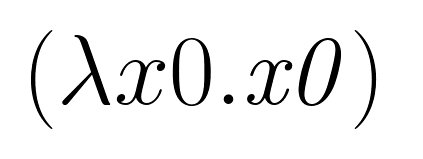

In [51]:
entry_trs.normalize(trs.normalize(c)).render_tex()